In [1]:
import numpy as np
import scipy
import scipy.optimize
import scipy.io as sio
from scipy.optimize import minimize, NonlinearConstraint
import matplotlib.pyplot as plt
from gca import gc_block_covariance, gca_obj, gca_obj_v, gca_obj_w, unit_norm

In [2]:
## Generate VAR process
L=3 # VAR model order
P=2 # number of pairs that we will ask GCA to compute
K=3 # number of latent sources
D=4 # number of sensors
N=5000 # number of time points
sigma_inn=1 # standard deviation of innovation process
sigma_sensor=0.01 # standard deviation of additive noise

In [3]:
## Define VAR matrix of latent sources
r1=0.9
theta1=40/120*2*np.pi
r2=0.7
theta2=10/120*2*np.pi
r3=0.8
theta3=50/120*2*np.pi

B = np.zeros(shape=(K,K,L))

#create the VAR system matrix here
B[:,:,0] = [ [2*r1*np.cos(theta1), 0, 0], [-0.356, 2*r2*np.cos(theta2), 0], [0, -0.3098, 2*r3*np.cos(theta3)] ]
B[:,:,1]= [ [-r1**2, 0, 0], [0.7136, -r2**2, 0], [0, 0.5, -r3**2] ]
B[:,:,2] = [ [0, 0, 0], [-0.356, 0, 0], [0, -0.3098, 0] ]

B.shape

(3, 3, 3)

In [4]:
# generate the dynamics of the latent sources
S = np.zeros(shape=(K,N))
S[:,0:L] = np.random.randn(K,L)
for n in range(L,N):
    for p in range(0,L):
        S[:,n]=B[:,:,p] @ S[:,n-p]
    S[:,n]+=sigma_inn*np.random.randn(K,)

In [5]:
## simulate the observations
A = np.random.rand(D,K)
X = A@S + sigma_sensor*np.random.randn(D,N)

In [6]:
## center the data in X
X = X - np.tile( np.mean(X, axis=1) , (N,1) ).T

In [7]:
## standardize the data in X
X = X / np.tile( np.std(X, axis=1) , (N,1) ).T

In [8]:
# form a copy of X but with time reversed
Xr = np.fliplr(X)

In [9]:
# samples, then channels
X = X.T
Xr = Xr.T
X.shape, Xr.shape

((5000, 4), (5000, 4))

## Bring in synthetic VAR data

In [10]:
results = {'data': X} # initialize results dictionary

n_pairs = 2
max_iters = 300
opt_tol = 1e-6
method="trust-constr"

# initialize v and w
v = 0.001 * np.random.randn(D,)
w = 0.001 * np.random.randn(D,)

for p in range(1,n_pairs+1):

    blkR1, Rtilde = gc_block_covariance(X,L) # forward time
    blkR1r, Rtilder = gc_block_covariance(Xr,L) # reverse time

    fval_v_last = np.inf
    fval_w_last = np.inf

    for iter in range(max_iters):

            print(p, iter)

            optres_v = minimize(gca_obj_v, 0.01*np.random.randn(D,), args=( (w, blkR1, Rtilde, blkR1r, Rtilder) ) ,  constraints=[scipy.optimize.NonlinearConstraint(unit_norm, 1, 1)])

            v = optres_v.x
            fval_v = optres_v.fun
            del_fval_v = np.abs(fval_v_last - fval_v)
            fval_v_last = fval_v

            optres_w = minimize(gca_obj_w, 0.01*np.random.randn(D,), args=( (v, blkR1, Rtilde, blkR1r, Rtilder) ) , constraints=[scipy.optimize.NonlinearConstraint(unit_norm, 1, 1)])

            w = optres_w.x
            fval_w = optres_w.fun
            del_fval_w = np.abs(fval_w_last - fval_w)
            fval_w_last = fval_w

            if del_fval_v < opt_tol and del_fval_w < opt_tol:
                print(f"Converged in {iter} iterations")
                break

    if iter == max_iters-1:
        print(f"Warning: did not converge in {max_iters} iterations")

    # compute the driven signal
    y_hat = X@w
    z_hat = X@v

    y_hat_og = results['data']@w
    z_hat_og = results['data']@v

    # form a convolution matrix from y_hat
    convmat = scipy.linalg.convolution_matrix(y_hat, L, mode='full')[0:-L+1,:]

    # add a column of ones to convmat
    convmat = np.concatenate((convmat, np.ones((convmat.shape[0],1))), axis=1)

    # regress out y_hat from x
    X = X - convmat@np.linalg.pinv(convmat)@X
    Xr = np.flipud(X)

    # store results
    results[p] = {'v': v, 'w': w,
                  'y_hat': y_hat, 'z_hat': z_hat,
                  'y_hat_og': y_hat_og, 'z_hat_og': z_hat_og,
                  'optres_v': optres_v, 'optres_w': optres_w}


1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 62
1 63
1 64
1 65
1 66
1 67
1 68
1 69
1 70
1 71
1 72
1 73
1 74
1 75
1 76
1 77
1 78
1 79
1 80
1 81
1 82
1 83
1 84
1 85
1 86
1 87
1 88
1 89
1 90
1 91
1 92
1 93
1 94
1 95
1 96
1 97
1 98
1 99
1 100
1 101
1 102
1 103
1 104
1 105
1 106
1 107
1 108
1 109
1 110
1 111
1 112
1 113
1 114
1 115
1 116
1 117
1 118
1 119
1 120
1 121
1 122
1 123
1 124
1 125
1 126
1 127
1 128
1 129
1 130
1 131
1 132
1 133
1 134
1 135
1 136
1 137
1 138
1 139
1 140
1 141
1 142
1 143
1 144
1 145
1 146
1 147
1 148
1 149
1 150
1 151
1 152
1 153
1 154
1 155
1 156
1 157
1 158
1 159
1 160
1 161
1 162
1 163
1 164
1 165
1 166
1 167
1 168
1 169
1 170
1 171
1 172
1 173
1 174
1 175
1 176
1 177
1 178
1 179
1 180
1 181
1 182
1 183
1 184


In [14]:
np.corrcoef(results[1]['y_hat_og'],S[0,:]), np.corrcoef(results[1]['z_hat_og'],S[1,:])

(array([[ 1.        , -0.99928025],
        [-0.99928025,  1.        ]]),
 array([[1.        , 0.99968522],
        [0.99968522, 1.        ]]))

In [16]:
np.corrcoef(results[2]['y_hat_og'],S[1,:]), np.corrcoef(results[2]['z_hat'],S[2,:])

(array([[1.        , 0.97801018],
        [0.97801018, 1.        ]]),
 array([[ 1.        , -0.99444122],
        [-0.99444122,  1.        ]]))

In [14]:
results[1]['w'].T@A, results[1]['v'].T@A, results[2]['w'].T@A, results[2]['v'].T@A,

(array([-0.44518064, -0.31768936, -0.23376872]),
 array([-0.02091183,  0.31815172,  0.009271  ]),
 array([-0.13810383, -0.19190405,  0.03317367]),
 array([ 0.3841249 ,  0.19729592, -0.0235038 ]))

In [11]:
#gca_obj(optres.x,blkR1,Rtilde,blkR1r,Rtilder)

array([[-0.11388443]])

In [12]:
#vstar=optres.x[0:D]
#wstar=optres.x[D:2*D+1]

<StemContainer object of 3 artists>

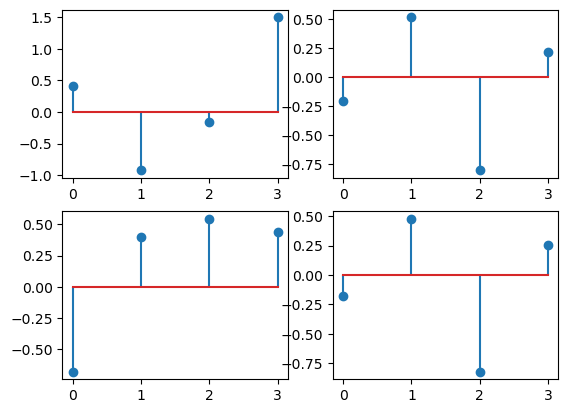

In [30]:
fig, ax = plt.subplots(2,2)
ax[0,0].stem(vtrue)
ax[0,1].stem(v)
ax[1,0].stem(wtrue)
ax[1,1].stem(w)

In [33]:
w.T@A, wtrue.T@A

(array([-0.02084364, -0.00018972, -0.00039625]),
 array([1.00000000e+00, 2.45775074e-16, 2.26972804e-16]))

In [34]:
v.T@A, vtrue.T@A

(array([ 0.00127161, -0.03189154,  0.00136117]),
 array([ 1.18650568e-16,  1.00000000e+00, -1.48052910e-16]))

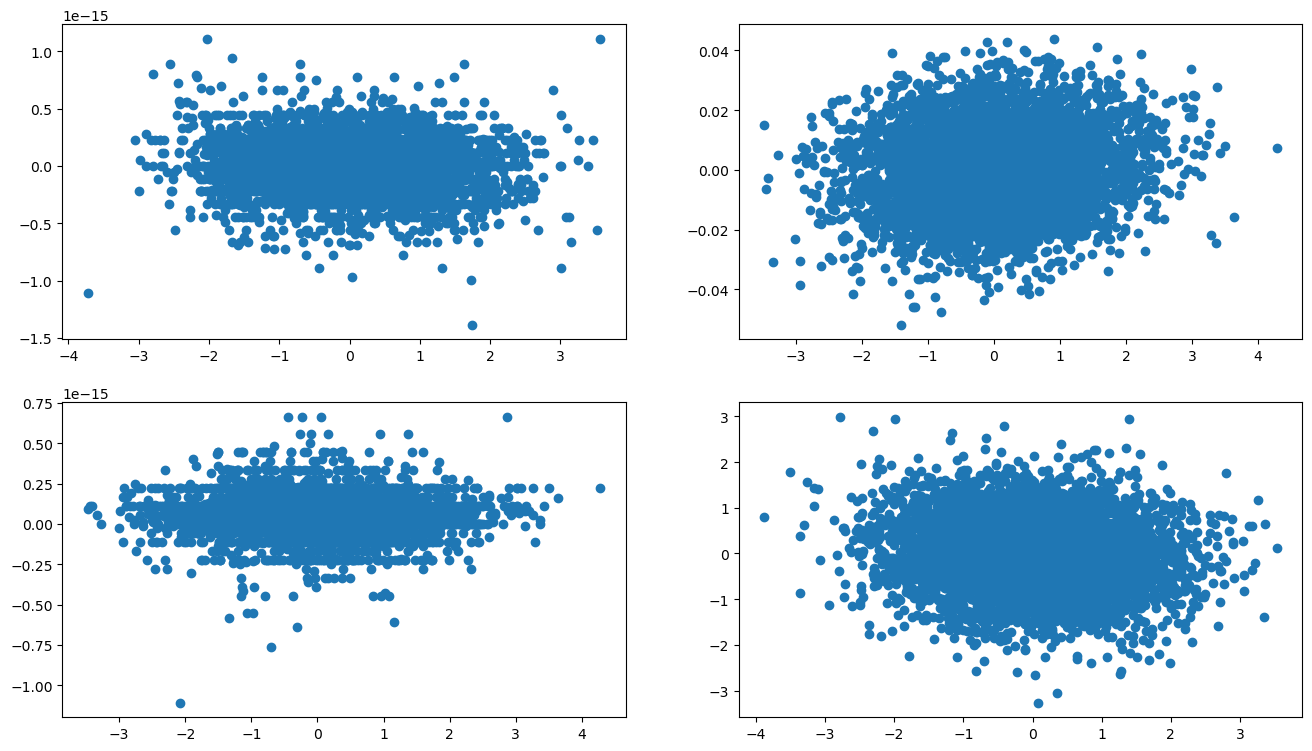

In [12]:
y_hat_1 = x@results[1]['w']
z_hat_1 = x@results[1]['v']
y_hat_2 = x@results[2]['w']
z_hat_2 = x@results[2]['v']
fig, ax = plt.subplots(2,2,figsize=(16,9))
ax[0,0].scatter(s1,y_hat_1)
ax[0,1].scatter(s2,z_hat_1)
ax[1,0].scatter(s2,y_hat_2)
ax[1,1].scatter(s3,z_hat_2)

In [70]:
convmat = scipy.linalg.convolution_matrix(y_hat, L, mode='full')[0:-L+1,:]
# add a column of ones to convmat
convmat = np.concatenate((convmat, np.ones((convmat.shape[0],1))), axis=1)
convmat.shape

(5000, 4)

In [73]:
x_ = x - convmat@np.linalg.pinv(convmat)@x

In [76]:
x_.shape, y_hat.shape

((5000, 4), (5000,))

In [82]:
np.corrcoef( np.squeeze(x_[:,0]), y_hat), np.corrcoef( np.squeeze(x[:,0]), y_hat)

(array([[1.00000000e+00, 1.75269571e-16],
        [1.75269571e-16, 1.00000000e+00]]),
 array([[ 1.        , -0.06575996],
        [-0.06575996,  1.        ]]))

In [83]:
np.roll([1,2,3],1)

array([3, 1, 2])

In [96]:
np.corrcoef( np.squeeze(x_[:,0]), np.roll(y_hat,2)), np.corrcoef( np.squeeze(x[:,0]), np.roll(y_hat,2))

(array([[1.00000000e+00, 5.96377947e-05],
        [5.96377947e-05, 1.00000000e+00]]),
 array([[1.        , 0.00634173],
        [0.00634173, 1.        ]]))

In [94]:
convmat[0:5,:], y_hat[0:5], x.shape, y_hat.shape

(array([[ 0.00105661,  0.        ,  0.        ,  1.        ],
        [ 0.00554403,  0.00105661,  0.        ,  1.        ],
        [-0.00182125,  0.00554403,  0.00105661,  1.        ],
        [ 0.01118145, -0.00182125,  0.00554403,  1.        ],
        [ 0.01582905,  0.01118145, -0.00182125,  1.        ]]),
 array([ 0.00105661,  0.00554403, -0.00182125,  0.01118145,  0.01582905]),
 (5000, 4),
 (5000,))

Code for generating VAR data is below

In [13]:
#B = np.array([[0.9, 0], [-0.2, 0.8]])

#D=x.shape[0] # of sensors
#M=2 # of sources
#L=1 # max lag of AR model
#T=50000 # of time samples
#noisepwr=1
#A = np.random.rand(D,M) # mixing matrix
#sensornoisepwr=0.1

# latent sources
#s = np.zeros(shape=(M,T))
#s[:,0:L] = np.random.randn(M,L)
#sinn = noisepwr*np.random.randn(M,T)

In [14]:
#for t in range(L,T):
#    s[:,t] = B@s[:,t-1] + sinn[:,t]
#x = A@s + sensornoisepwr*np.random.randn(D,T)

## Evaluate GCA objective with ground-truth spatial filters
s1 is the driving signal (recovered by wtrue)
s2 is the driven signal (recovered by vtrue)

In [19]:
#pinvA=np.linalg.pinv(A.T)
#wtrue=pinvA[:,0]
#vtrue=pinvA[:,1]
#x_gt=np.concatenate( ( vtrue , wtrue ) ,axis=0 )
#gca_obj(x_gt, blkR1, Rtilde, blkR1r, Rtilder)

In [2]:
x = scipy.io.loadmat('../Xtest3.mat')['x']

# mean center x
x = x - np.mean(x, axis=0)

# standardize x
x = x / np.std(x, axis=0)

xog = x.copy()
stats = scipy.io.loadmat('../Xtest3.mat')['stats']
xr = np.flipud(x)

A = stats['A'][0][0]
D=4
L=3

s1=stats['S'][0][0][0,:]
s2=stats['S'][0][0][1,:]
s3=stats['S'][0][0][2,:]